Import Libraries for Visualization

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import os

Load results

In [2]:
def load_results(results_path):
    with open(results_path, 'r') as file:
        data = json.load(file)
    results = {}
    for feature_set, models in data.items():
        results[feature_set] = models
    return results

results_path = '../results/model_results.json'
model_results = load_results(results_path)


def load_pred_results(results_path):
    with open(results_path, 'r') as file:
        data = json.load(file)
    pred_results = {}
    for feature_set, models in data.items():
        pred_results[feature_set] = models
    return pred_results

results_path = '../results/pred_results.json'
pred_results = load_pred_results(results_path)

Save results as Pandas Dataframe and csv

In [3]:
def metrics(results):
    
    metrics = []
    for feature_set, models in results.items():
        for model, data in models.items():
            metrics.append({
                'Feature_Set': feature_set,
                'Model': model,
                'CV Accuracy': data['cv_accuracy'],
                'Accuracy': data['test_accuracy'],
                'Precision Score': data['test_precision'],
                'Recall Score': data['test_recall'],
                'F1 Score': data['test_f1'],
                "Cohen's Kappa Score": data['cohen_kappa'],
            })

    df = pd.DataFrame(metrics)
    return df
    
metrics_df = metrics(model_results)

#Save to CSV
metrics_df.to_csv('../results/model_results.csv', index=False)
metrics_df

,Feature_Set,Model,CV Accuracy,Accuracy,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score
0,F_fanger,ET,0.736403,0.751663,0.752864,0.761154,0.755814,0.625499
1,F_fanger,RF,0.738330,0.749446,0.748920,0.760898,0.751993,0.623189
2,F_fanger,SVC,0.702162,0.676275,0.676017,0.693547,0.676409,0.514979
3,F_selected,ET,0.845826,0.817276,0.817346,0.823884,0.819791,0.724442
4,F_selected,RF,0.842260,0.810631,0.811458,0.816568,0.813556,0.714098
5,F_selected,SVC,0.862966,0.823920,0.823870,0.833799,0.826366,0.735290
6,F_accessible,ET,0.823015,0.802661,0.803463,0.809746,0.806107,0.702122
7,F_accessible,RF,0.810666,0.809313,0.810080,0.812696,0.811290,0.711557
8,F_accessible,SVC,0.811596,0.818182,0.817256,0.827654,0.820150,0.726499


Metrics Plot for Feature Sets

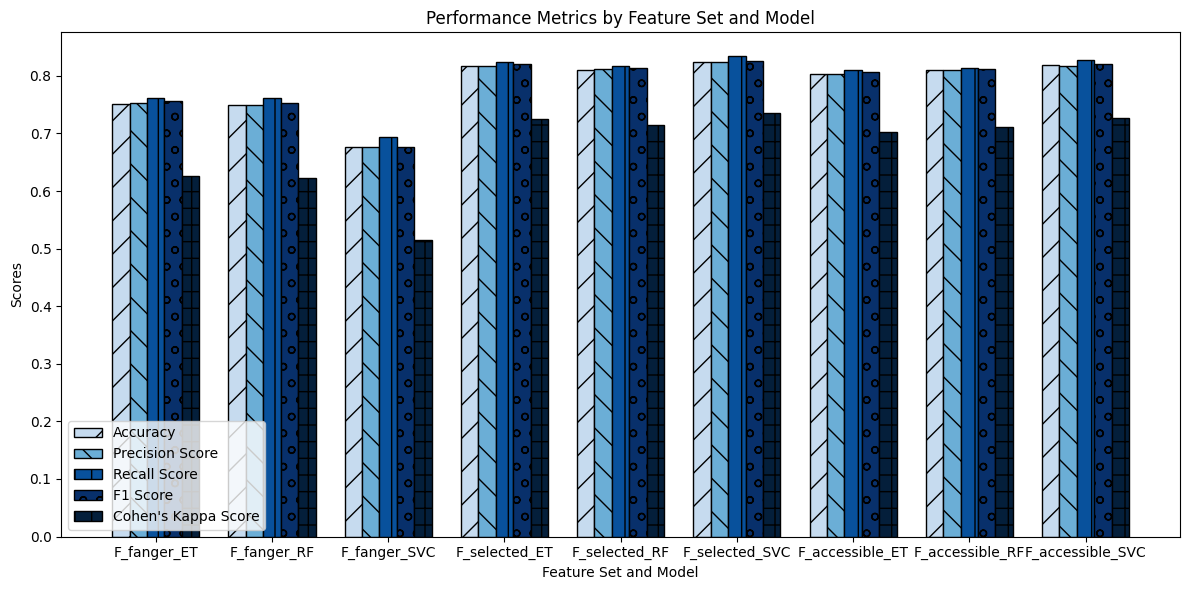

In [4]:
def plot_abs_metrics():
    metrics_to_plot = ['Accuracy', 'Precision Score', 'Recall Score', 'F1 Score', "Cohen's Kappa Score"]
    df = metrics_df.copy()
    df['Feature_Model'] = df['Feature_Set'] + '_' + df['Model']

    barWidth = 0.15
    r = np.arange(len(df))
    positions = [r + (i * barWidth) for i in range(len(metrics_to_plot))]

    colors = ['#c6dbef', '#6baed6', '#08519c', '#08306b', '#041f3b']
    hatches = ['/', '\\', '|', 'o', '+']

    plt.figure(figsize=(12, 6))
    for i, (metric, color, hatch) in enumerate(zip(metrics_to_plot, colors, hatches)):
        plt.bar(positions[i], df[metric], width=barWidth, color=color, edgecolor='black', 
                hatch=hatch, label=metric)

    plt.xlabel('Feature Set and Model')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Feature Set and Model')
    plt.xticks([r + (len(metrics_to_plot) - 1) * barWidth / 2 for r in range(len(df))], df['Feature_Model'])
    plt.legend(loc='lower left') 
    plt.tight_layout()
    plt.savefig('../results_plots/graph_abs_plot.png', bbox_inches='tight')
    plt.show()

plot_abs_metrics()


Plot classification report heatmap

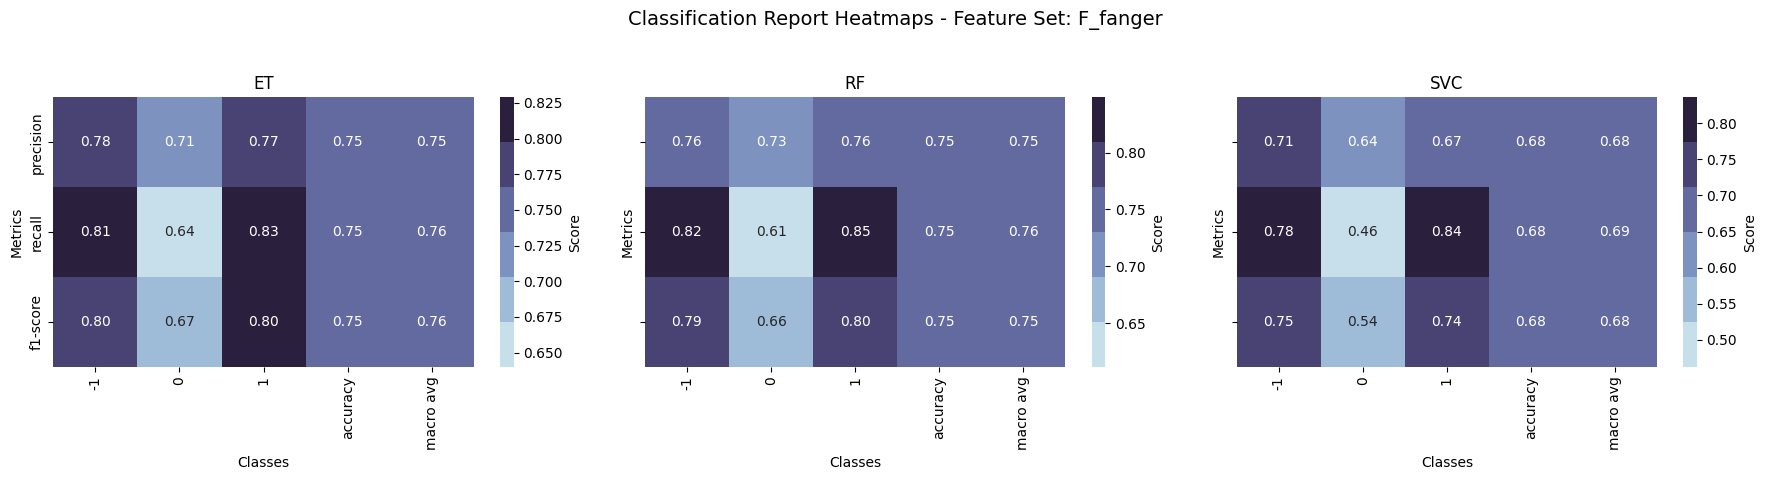

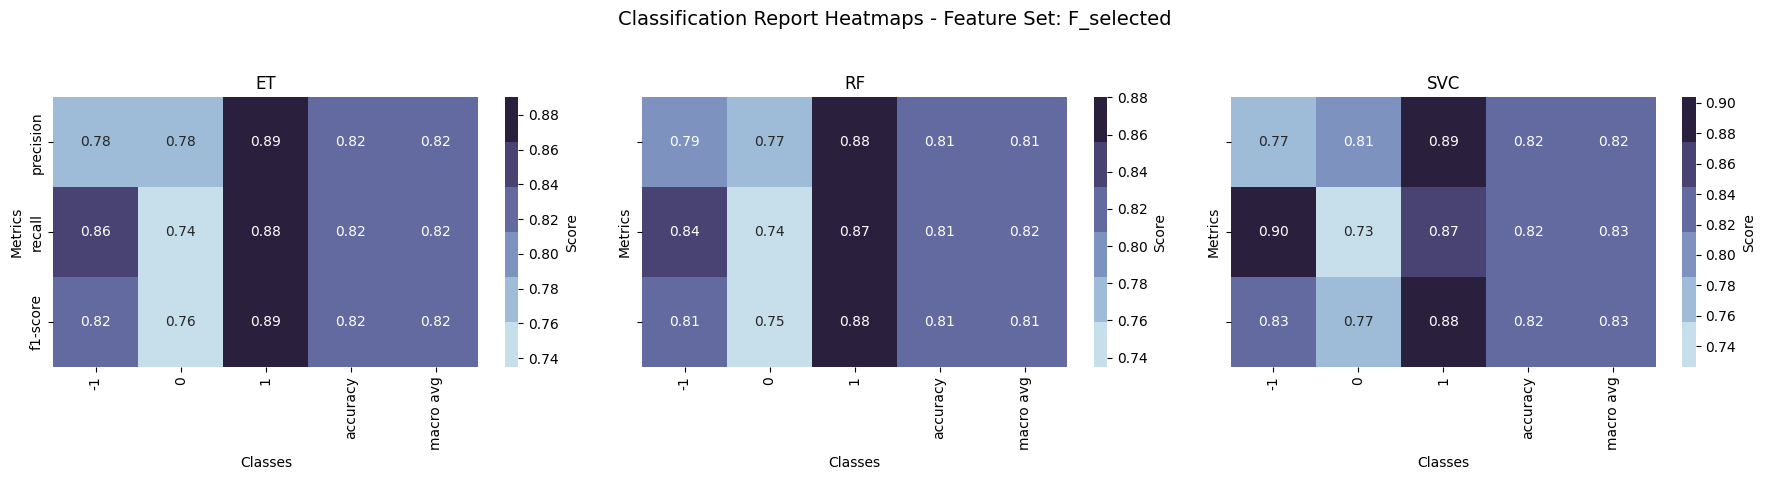

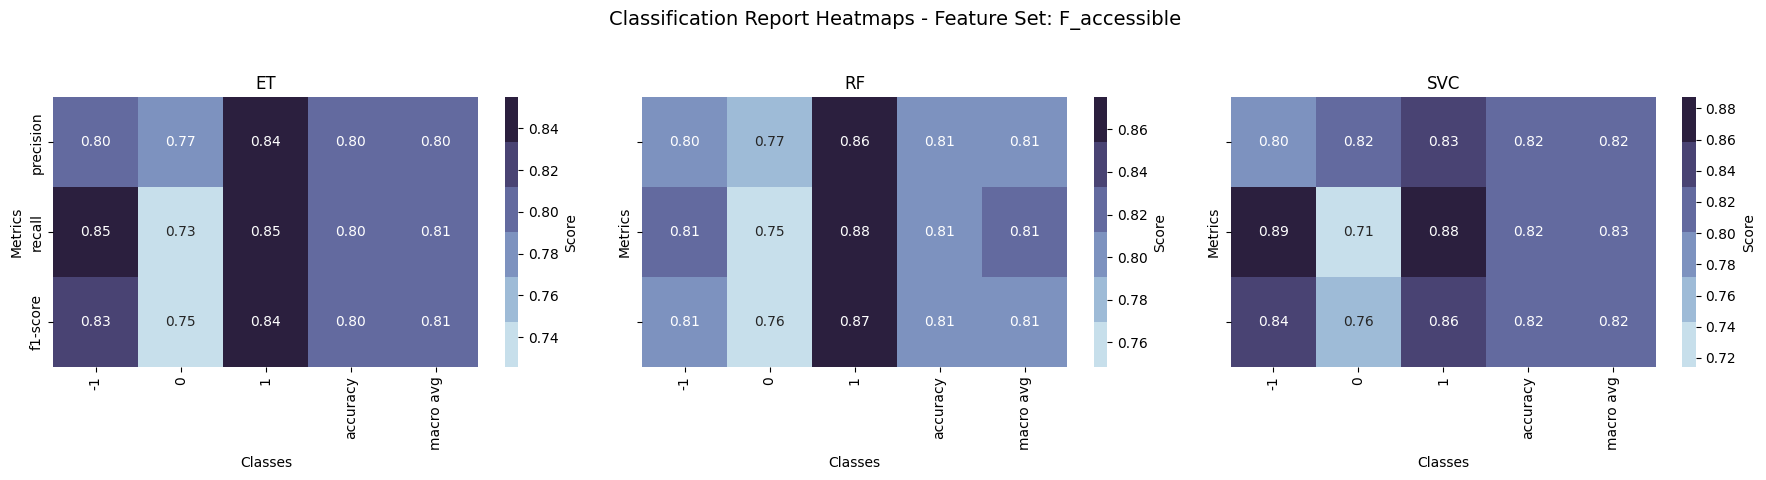

In [5]:
def plot_classification_report_grouped_by_feature_set(results):
    for feature_set, models in results.items():
        num_models = len(models)
        fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5), sharey=True)
        if num_models == 1:
            axes = [axes]

        for ax, (model, data) in zip(axes, models.items()):
            y_test = data['y_test']
            y_pred = data['y_pred']

            report = classification_report(y_test, y_pred, output_dict=True)
            report_df = pd.DataFrame(report).transpose().drop(columns=["support"])

            sns.heatmap(
                report_df.iloc[:-1, :].T, annot=True, fmt=".2f", ax=ax,
                cmap=sns.color_palette('ch:s=.25,rot=-.25'),
                cbar_kws={'label': 'Score'}
            )
            ax.set_title(f"{model}")
            ax.set_ylabel("Metrics")
            ax.set_xlabel("Classes")

        plt.suptitle(f"Classification Report Heatmaps - Feature Set: {feature_set}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f'../results_plots/class_report_grouped_{feature_set}.png', bbox_inches='tight')
        plt.show()

plot_classification_report_grouped_by_feature_set(pred_results)


Plot confusion matrix

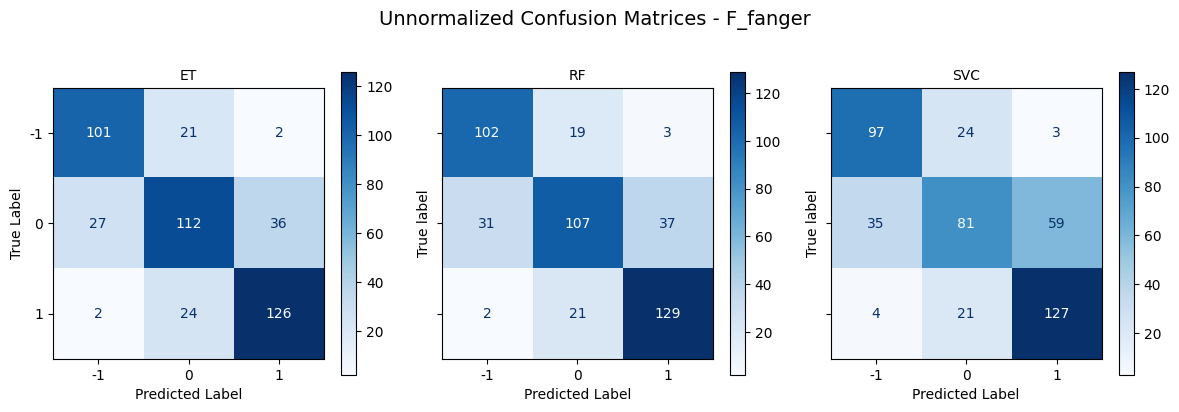

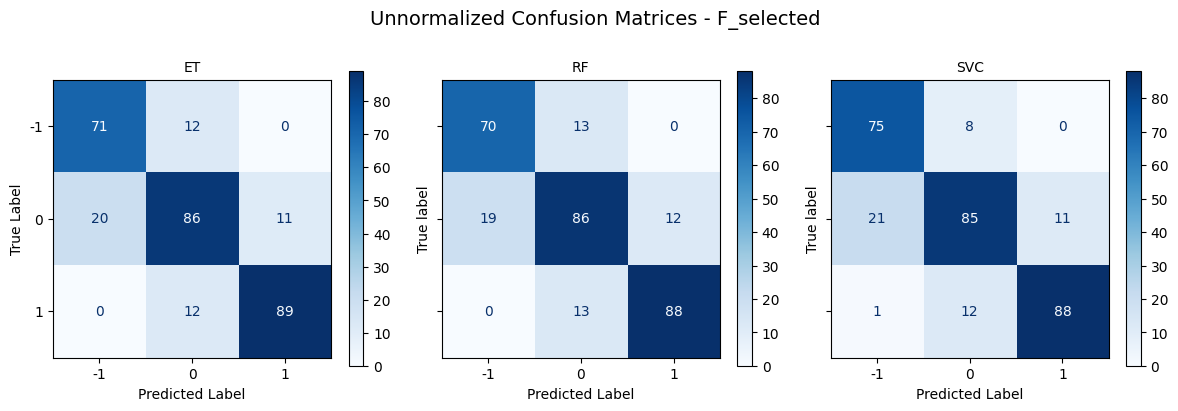

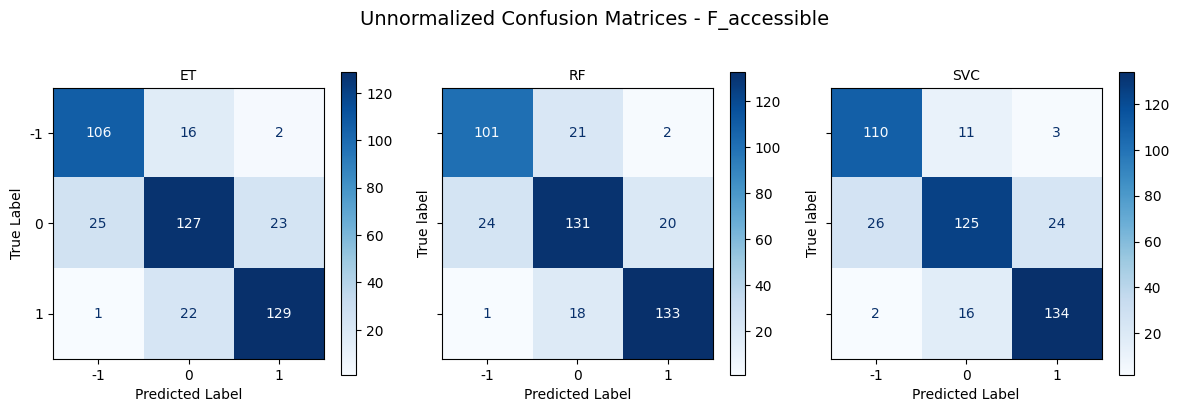

In [6]:
def plot_raw_confusion_by_feature_set(results):

    models = ['ET', 'RF', 'SVC']
    labels = [-1, 0, 1]

    for feature_set, model_data in results.items():
        fig, axs = plt.subplots(1, len(models), figsize=(4 * len(models), 4), sharey=True)

        for i, model in enumerate(models):
            ax = axs[i] if len(models) > 1 else axs
            if model in model_data:
                y_test = model_data[model]['y_test']
                y_pred = model_data[model]['y_pred']

                ConfusionMatrixDisplay.from_predictions(
                    y_test,
                    y_pred,
                    display_labels=labels,
                    normalize=None,
                    cmap='Blues',
                    ax=ax
                )
                ax.set_title(f"{model}", fontsize=10)
                ax.set_xlabel("Predicted Label")
                if i == 0:
                    ax.set_ylabel("True Label")

        plt.suptitle(f"Unnormalized Confusion Matrices - {feature_set}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig((f'../results_plots/unnormalized_cm_{feature_set}.png'), dpi=300)
        plt.show()

plot_raw_confusion_by_feature_set(pred_results)

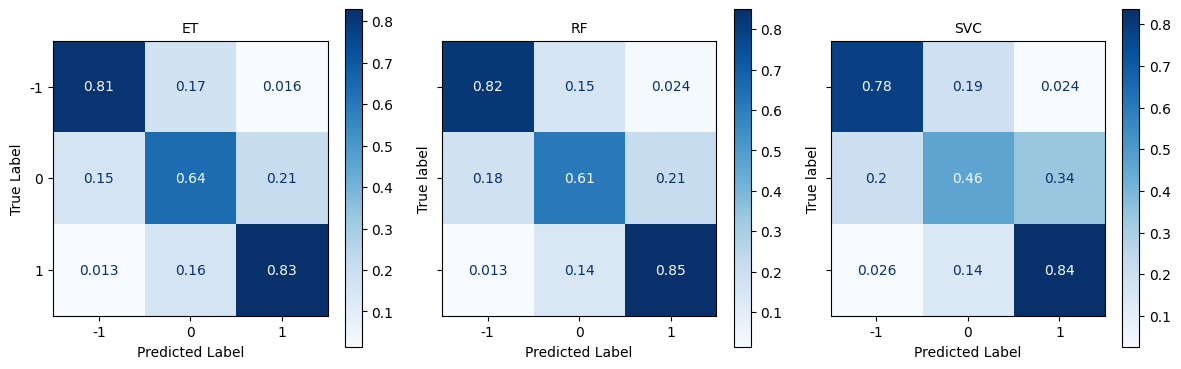

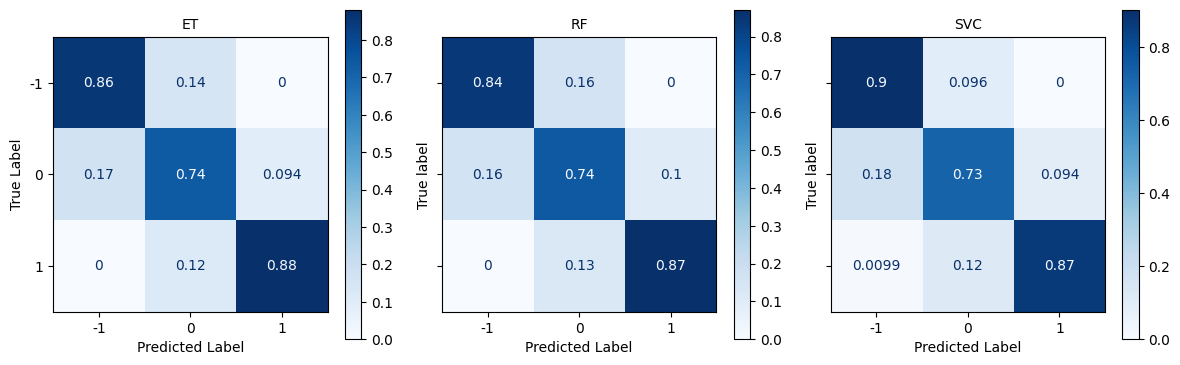

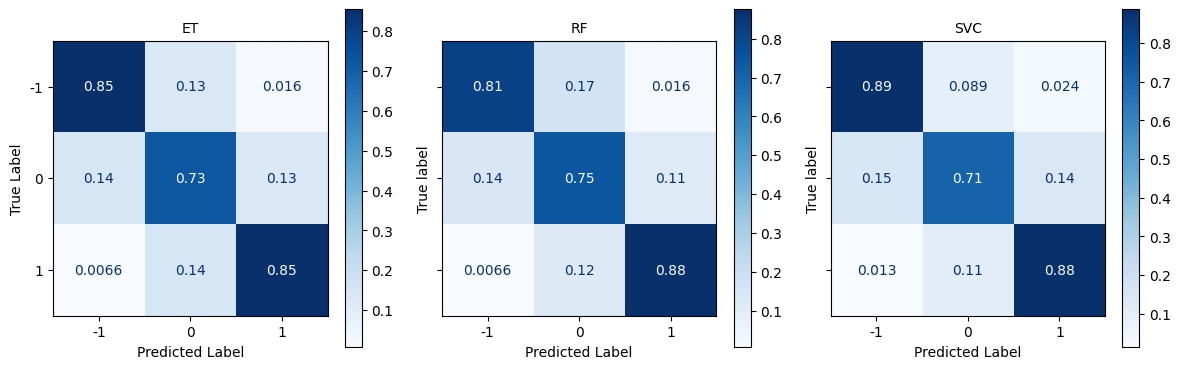

In [7]:
def plot_normalized_confusion_by_feature_set(results):
    models = ['ET', 'RF', 'SVC']
    labels = [-1, 0, 1]

    for feature_set, model_data in results.items():
        fig, axs = plt.subplots(1, len(models), figsize=(4 * len(models), 4), sharey=True)

        for i, model in enumerate(models):
            ax = axs[i] if len(models) > 1 else axs
            if model in model_data:
                y_test = model_data[model]['y_test']
                y_pred = model_data[model]['y_pred']

                ConfusionMatrixDisplay.from_predictions(
                    y_test, y_pred,
                    display_labels=labels,
                    normalize='true',
                    cmap='Blues',
                    ax=ax
                )
                ax.set_title(f"{model}", fontsize=10)
                ax.set_xlabel("Predicted Label")
                if i == 0:
                    ax.set_ylabel("True Label")

        #plt.suptitle(f'Normalized Confusion Matrices - {feature_set}', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig((f'../results_plots/normalized_confusion_{feature_set}.png'), dpi=300)
        plt.show()

plot_normalized_confusion_by_feature_set(pred_results)

Density Distribution of predicted vs actual in the test data

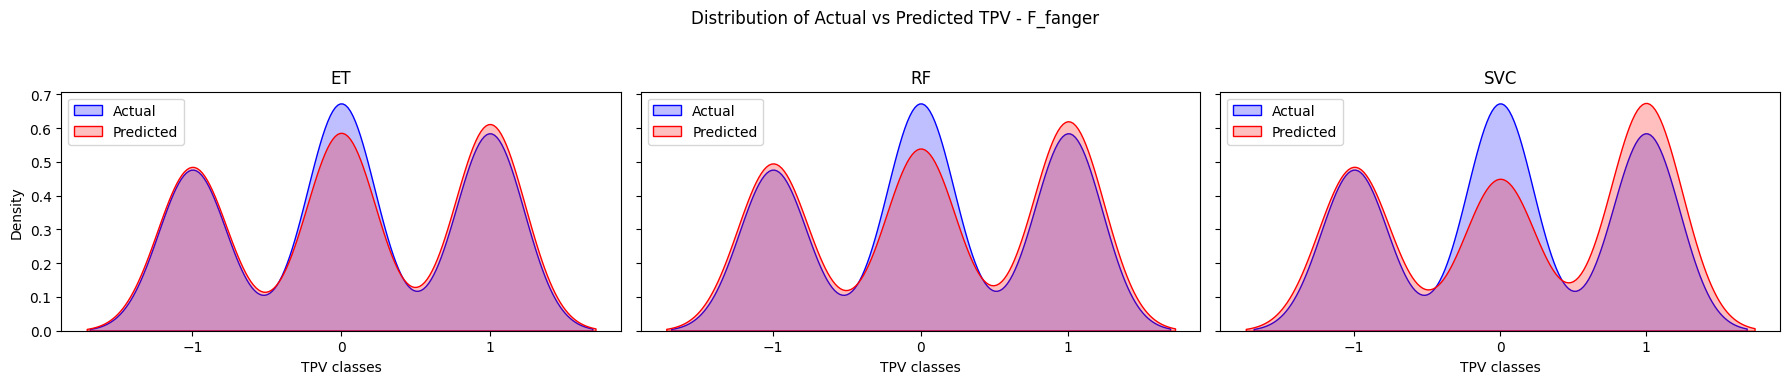

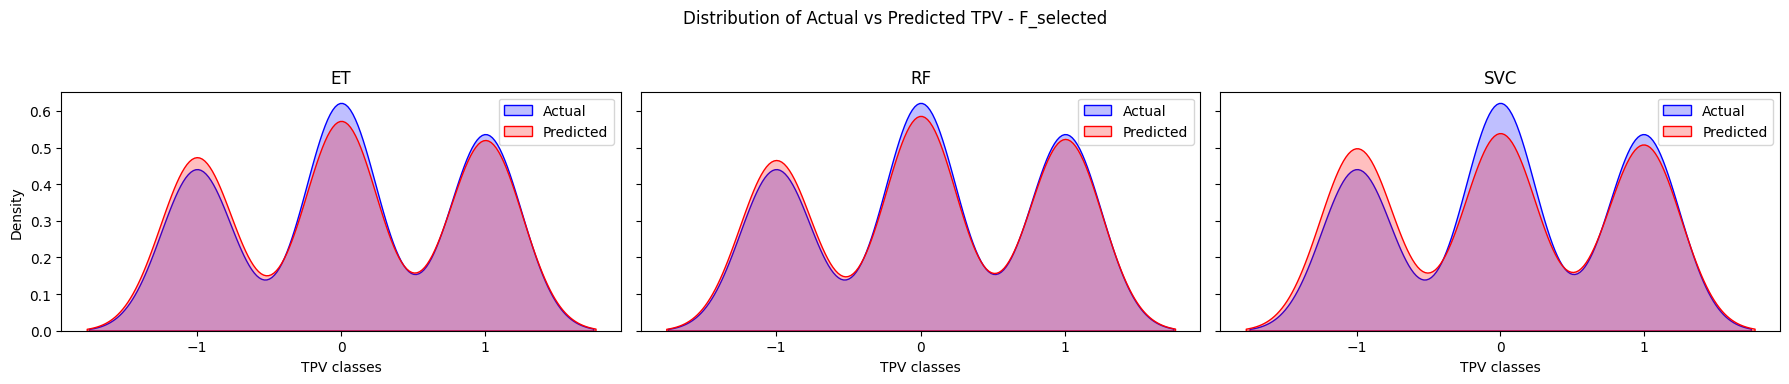

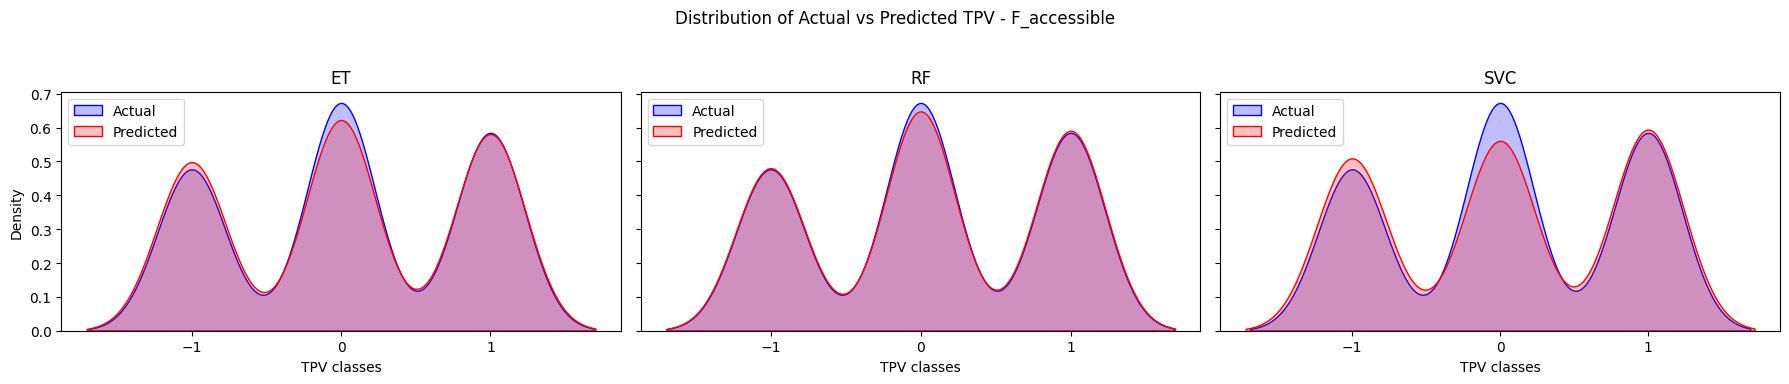

In [8]:
def plot_distributions_grouped_by_feature_set(results):
    for feature_set, models in results.items():
        num_models = len(models)
        fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 4), sharey=True)
        if num_models == 1:
            axes = [axes]  
            
        for ax, (model, data) in zip(axes, models.items()):
            y_test = data['y_test']
            y_pred = data['y_pred']

            if hasattr(y_test, 'shape') and len(y_test.shape) > 1:
                y_test = [item for sublist in y_test for item in sublist]
            if hasattr(y_pred, 'shape') and len(y_pred.shape) > 1:
                y_pred = [item for sublist in y_pred for item in sublist]

            sns.kdeplot(y_test, color='blue', label='Actual', fill=True, ax=ax)
            sns.kdeplot(y_pred, color='red', label='Predicted', fill=True, ax=ax)
            ax.set_title(f"{model}")
            ax.set_xlabel("TPV classes")
            ax.set_xticks([-1, 0, 1])
            ax.legend()

        plt.suptitle(f"Distribution of Actual vs Predicted TPV - {feature_set}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f'../results_plots/grouped_density_{feature_set}.png', bbox_inches='tight')
        plt.show()

plot_distributions_grouped_by_feature_set(pred_results)


ROC Curve plots

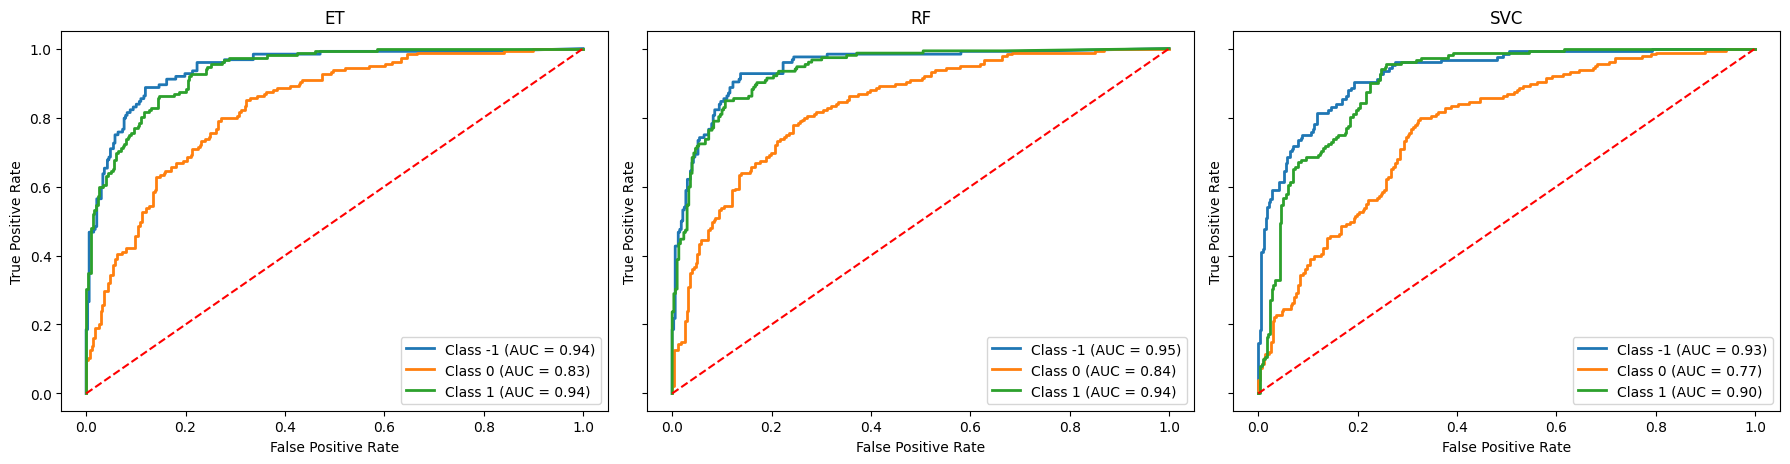

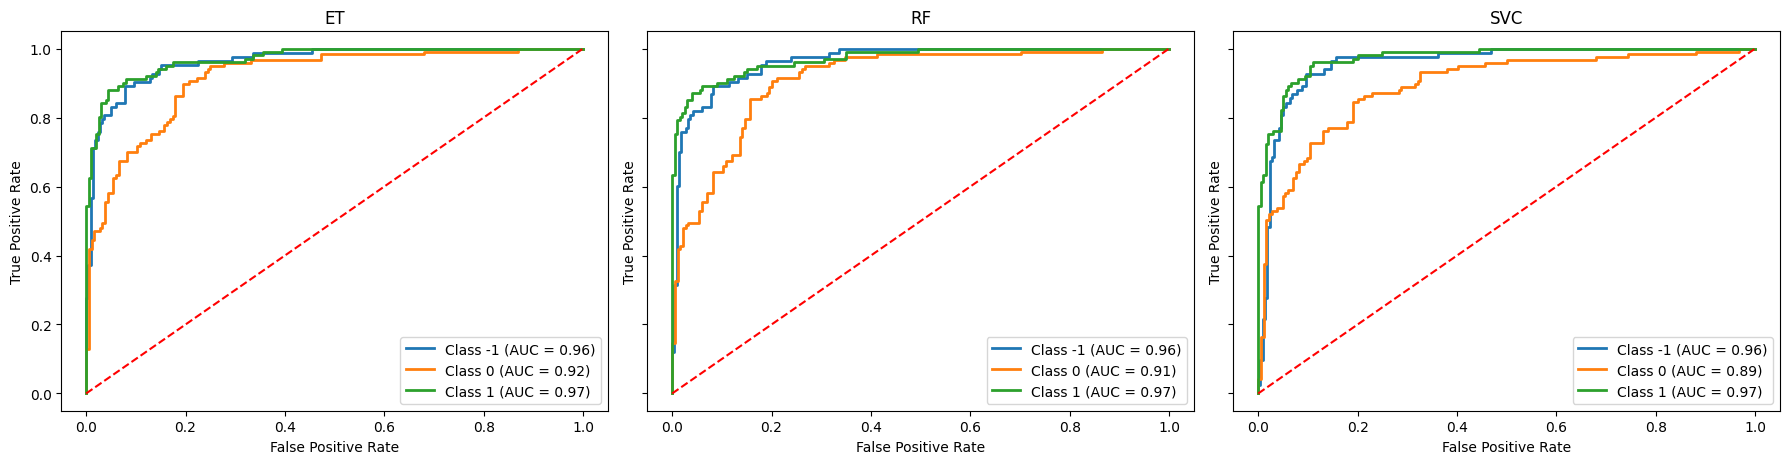

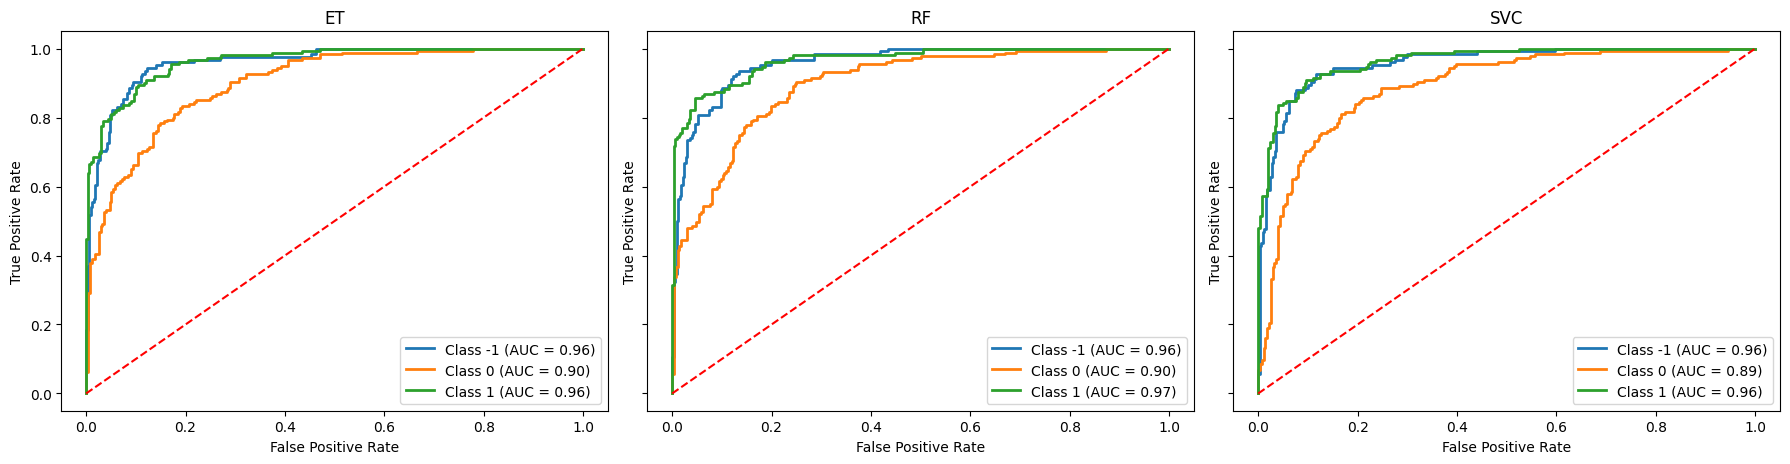

In [9]:
def plot_roc_curve(results):
    class_labels = ['Class -1', 'Class 0', 'Class 1']
    label_order = [-1, 0, 1]

    for feature_set, models in pred_results.items():
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

        for ax, (model_name, data) in zip(axes, models.items()):
            y_test = np.array(data['y_test'])
            y_proba = np.array(data['y_proba'])

            class_mapping = {label: idx for idx, label in enumerate(label_order)}
            y_test_mapped = np.array([class_mapping[label] for label in y_test])
            y_test_bin = label_binarize(y_test_mapped, classes=range(len(class_labels)))

            for class_idx in range(y_proba.shape[1]):
                fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], [probs[class_idx] for probs in y_proba])
                roc_auc = auc(fpr, tpr)
                ax.plot(fpr, tpr, lw=2, label=f"{class_labels[class_idx]} (AUC = {roc_auc:.2f})")

            ax.plot([0, 1], [0, 1], color='red', linestyle='--')
            ax.set_title(f"{model_name}")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc="lower right")

        #fig.suptitle(f'ROC Curves by Model - {feature_set}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'../results_plots/ROC_grouped_{feature_set}.png', bbox_inches='tight')
        plt.show()
plot_roc_curve(pred_results)

Precision-Recall Curve

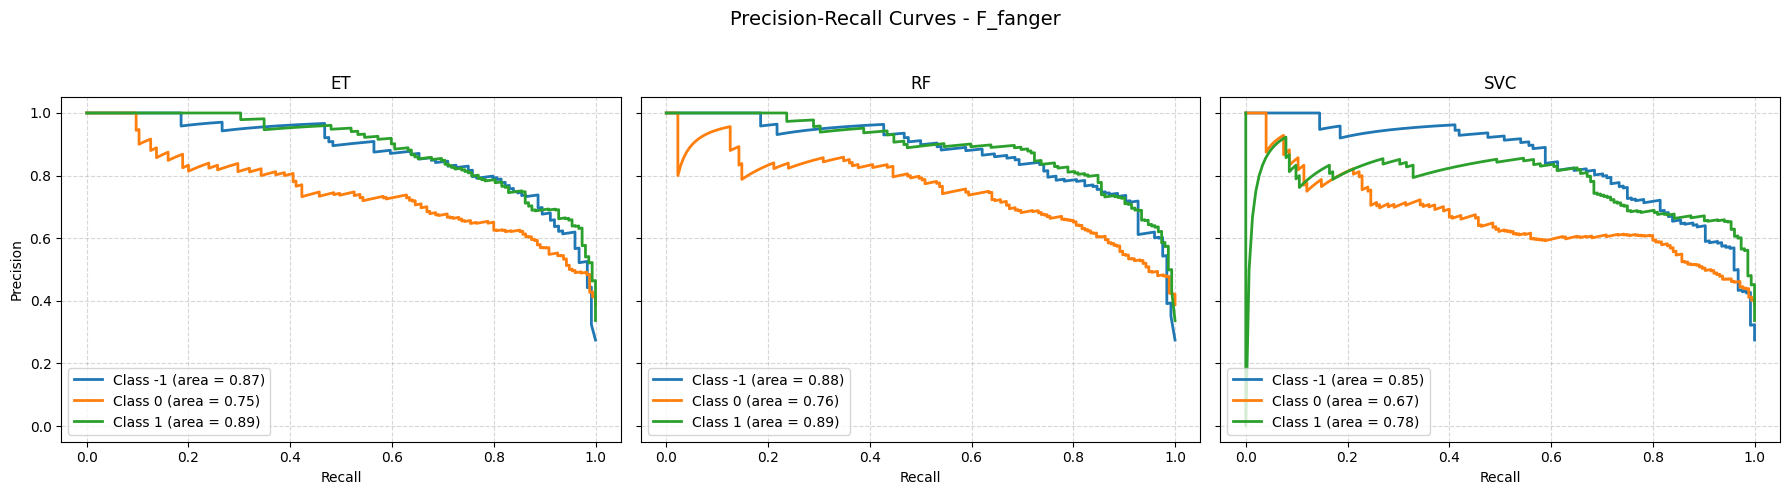

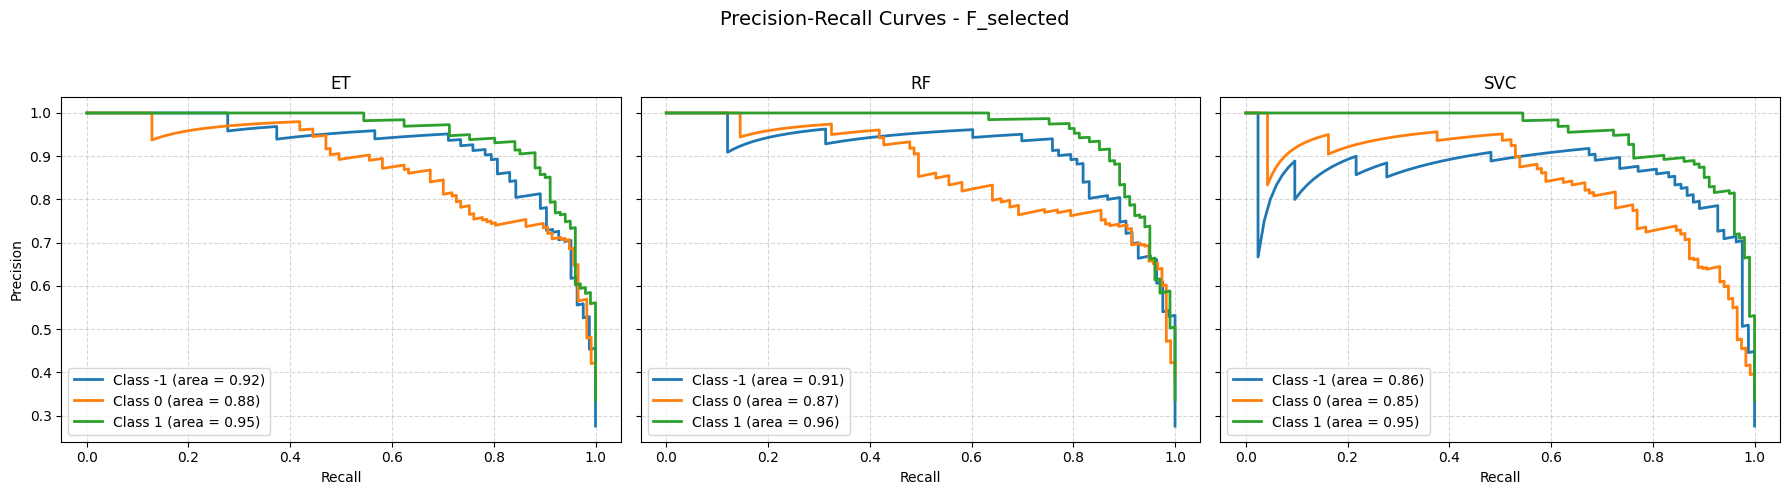

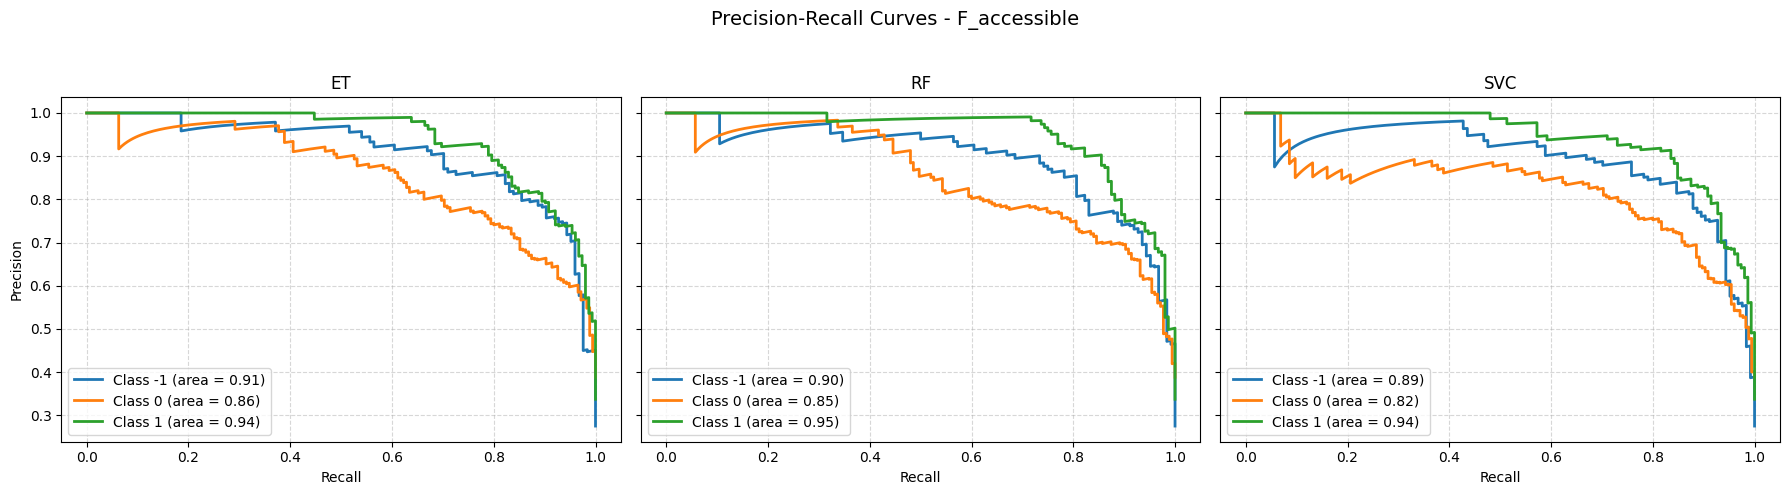

In [10]:
def plot_precision_recall(results):
    class_labels = ['Class -1', 'Class 0', 'Class 1']

    for feature_set, models in pred_results.items():
        fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        fig.suptitle(f"Precision-Recall Curves - {feature_set}", fontsize=14)

        for idx, (model, data) in enumerate(models.items()):
            y_test = np.array(data['y_test'])
            y_proba = np.array(data['y_proba'])

            y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])

            ax = axs[idx]
            for class_idx in range(y_proba.shape[1]):
                y_pred_proba_class = [probs[class_idx] for probs in y_proba]
                precision, recall, _ = precision_recall_curve(y_test_bin[:, class_idx], y_pred_proba_class)
                avg_precision = average_precision_score(y_test_bin[:, class_idx], y_pred_proba_class)
                ax.plot(recall, precision, lw=2, label=f'{class_labels[class_idx]} (area = {avg_precision:.2f})')

            ax.set_title(model)
            ax.set_xlabel('Recall')
            if idx == 0:
                ax.set_ylabel('Precision')
            ax.legend(loc='lower left')
            ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'../results_plots/grouped_pr_curves_{feature_set}.png', bbox_inches='tight')
        plt.show()
plot_precision_recall(pred_results)